## IFT870 - TP1 
### gibg2501 - leba3207
#### 7 février 2020

In [119]:
# some imports...
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
from mpl_toolkits.mplot3d import Axes3D

import scipy.spatial.distance as sdist
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Magical word to inline figures in jupyter notebook
%matplotlib notebook

# Disable annoyin warnings
import warnings
warnings.filterwarnings('ignore')

# removes maximum number of columns & rows for display
pd.options.display.max_columns = 7
pd.options.display.max_rows = 10

# Determine how many outputs per cells should be displayed
InteractiveShell.ast_node_interactivity = "last" #    'all', 'last', 'last_expr', 'none', 'last_expr_or_assign'

# Loads the data in a data frame
tp1_data_file = 'TP1_data.csv'
tp1_data = pd.read_csv(tp1_data_file, header=0, index_col=0)
tp1_data
headers = tp1_data.columns

# Create data frames for each classe
condition0 = tp1_data['classe'] == 0
condition1 = tp1_data['classe'] == 1
condition2 = tp1_data['classe'] == 2

tp1_data_classe_0 = tp1_data.loc[condition0 , 'attribut1':'attribut4']
tp1_data_classe_1 = tp1_data.loc[condition1 , 'attribut1':'attribut4']
tp1_data_classe_2 = tp1_data.loc[condition2 , 'attribut1':'attribut4']

Description des données statistiques de base du jeux de données

In [120]:
tp1_data.describe()

,attribut1,attribut2,attribut3,attribut4,classe
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627,0.915254
std,10.490782,3.531995,8.174992,4.057994,0.815542
min,28.700000,16.500000,0.000000,3.700000,0.000000
25%,40.850000,21.050000,2.400000,12.000000,0.000000
50%,49.000000,23.300000,9.000000,15.100000,1.000000
75%,59.200000,25.100000,13.000000,16.950000,2.000000
max,68.500000,33.000000,29.100000,23.000000,2.000000


Affichage des attributs du jeux de données paire à paire et quantification de la correlation à l'aide de la méthode de Pearson $$\left(\frac{cov(X,Y)}{\sigma_X\sigma_Y} \right)$$

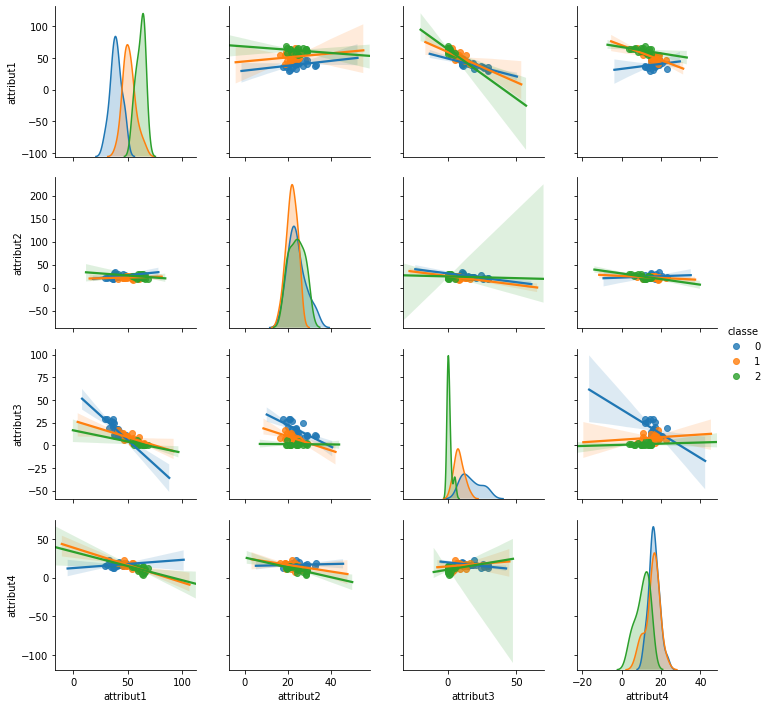

In [121]:
%matplotlib inline
sns.pairplot(tp1_data, vars=['attribut1', 'attribut2', 'attribut3', 'attribut4'],  hue='classe', kind='reg')



Corrélation inter-attributs pour la classe 0 

In [122]:
tp1_data_classe_0.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.302290,-0.784024,0.205335
attribut2,0.302290,1.000000,-0.671647,0.097789
attribut3,-0.784024,-0.671647,1.000000,-0.496368
attribut4,0.205335,0.097789,-0.496368,1.000000


Corrélation inter-attributs pour la classe 1

In [123]:
tp1_data_classe_1.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.137804,-0.590792,-0.726196
attribut2,0.137804,1.000000,-0.543282,-0.303635
attribut3,-0.590792,-0.543282,1.000000,0.142723
attribut4,-0.726196,-0.303635,0.142723,1.000000


Corrélation inter-attributs pour la classe 2

In [124]:
tp1_data_classe_2.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,-0.213961,-0.620437,-0.427720
attribut2,-0.213961,1.000000,-0.035696,-0.621881
attribut3,-0.620437,-0.035696,1.000000,0.136993
attribut4,-0.427720,-0.621881,0.136993,1.000000


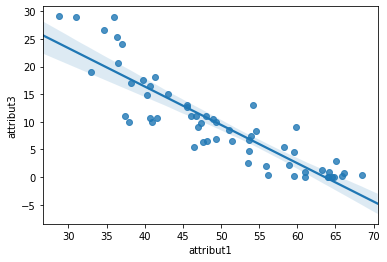

In [125]:
sns.regplot(tp1_data.loc[:,'attribut1'],tp1_data.loc[:,'attribut3'])

## Q1 & Q2
a) Les relations de corrélations sont visiblement différentes pour les 3 classes.
Par exemple, pour la classe 0 le 1er et le 3e, ainsi que le 2e et 3e attributs sont fortement et négativement corrélés.
Les attributs 3 et 4 sont encore négativement corrélés, mais beausoup plus faiblement. Ces corrélations ne tiennent cependant plus pour la classe 1 et 2.

Utilisation de la méthode de réduction en composantes principales ($$\textit{PCA}$$) pour quantifier les corrélations entre les attributs pour chaque classe

In [126]:
# Scale the features data and applies PCA tranform for all classes
# Scaling
scaler = StandardScaler()
features = tp1_data.loc[: , 'attribut1':'attribut4']
labels = tp1_data.loc[: , 'classe']
scaler.fit(features)
tp1_data_scaled = scaler.transform(features)

# PCA transform
PCA_data_tp1 = PCA(n_components = features.shape[1])
PCA_data_tp1.fit(tp1_data_scaled, labels)
transf_all = PCA_data_tp1.transform(tp1_data_scaled)

transf_all_labeled = pd.DataFrame(transf_all, columns = ['attribut1', 'attribut2', 'attribut3', 'attribut4'])
transf_all_labeled.insert(4, 'classe', labels.array)

# Create data frame from PCs
data_tp1_components = pd.DataFrame(PCA_data_tp1.components_, columns=list(features.columns))
tp1_components_ratios = PCA_data_tp1.explained_variance_ratio_

md('Les ratios d\'influence pour chaque composante principale: {}'.format(tp1_components_ratios))
md('On peut constater que les composta {} et {} ont une influence beaucoup plus grandes sur la variance que {} et {}. On peut donc laisser tomber ces dernières')

On peut constater que les composta {} et {} ont une influence beaucoup plus grandes sur la variance que {} et {}. On peut donc laisser tomber ces dernières

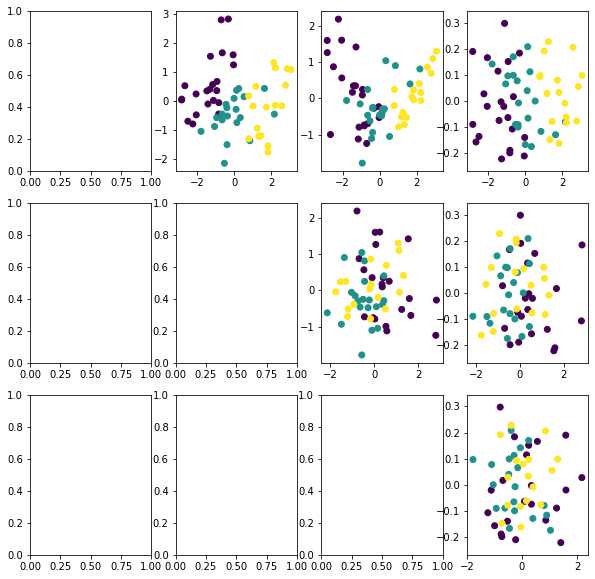

In [127]:
# Dipslay transformed features in 2D & 3D
n_features = features.shape[1]
fig, axes = plt.subplots(n_features - 1, n_features, figsize=(10,10))
k = 0
for i in range(n_features):
    for j in range(n_features):
        if(i<j):
            axes[i,j].scatter(transf_all[:, i], transf_all[:, j], c = labels)

        # axes[i,j].y_label['']
        k += 1

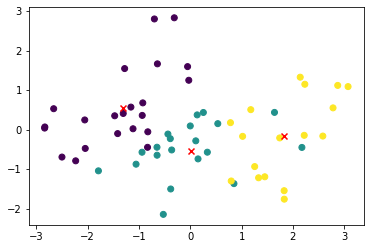

In [128]:
# Calculate ranges and create data frames for each class
lim_inf = 0
lim_1 = tp1_data_classe_0.shape[0]+1
lim_2 = lim_1 + tp1_data_classe_1.shape[0]
lim_3 = lim_2 + tp1_data_classe_2.shape[0]

transf_C0 = pd.DataFrame(transf_all[lim_inf:lim_1, :], columns = headers[0:4]) 
transf_C1 = pd.DataFrame(transf_all[lim_1-1:lim_2, :], columns = headers[0:4])
transf_C2 = pd.DataFrame(transf_all[lim_2-1:, :], columns = headers[0:4])

# Process clustering for each class
centroids_C0 = transf_C0.mean(axis=0)[0:3]
centroids_C1 = transf_C1.mean(axis=0)[0:3]
centroids_C2 = transf_C2.mean(axis=0)[0:3]

centroids = np.array([centroids_C0, centroids_C1, centroids_C2])

# Plot transformed features data according to the 2 best PC
plt.scatter(transf_all[:, 0], transf_all[:, 1], c = labels)

# Plots centroids
plt.scatter(centroids_C0[0], centroids_C0[1], marker='x', c='r')
plt.scatter(centroids_C1[0], centroids_C1[1], marker='x', c='r')
plt.scatter(centroids_C2[0], centroids_C2[1], marker='x', c='r')

In [129]:
def GetEuclidianDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.euclidean([transf_point[0], transf_point[1]],
                                       [centroids_arr [0, 0], centroids_arr [0, 1]])

            _dist_c1 = sdist.euclidean([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]])

            _dist_c2 = sdist.euclidean([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]])
        elif n_pc == 3:
            _dist_c0 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]])

            _dist_c1 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]])

            _dist_c2 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]])

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([index, calculated_classe, actual_classe])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

def GetManhattanDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1]])

            _dist_c1 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]])

            _dist_c2 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]])
        elif n_pc == 3:
            _dist_c0 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]])

            _dist_c1 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]])

            _dist_c2 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]])

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([index, calculated_classe, actual_classe])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

def GetMahalanobisDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    if n_pc == 2:
        _arr = np.array([transformed_values_labelled.loc[:,'attribut1'],transformed_values_labelled.loc[:,'attribut2']])
        _inv_cov = np.linalg.inv(np.cov(_arr))
    elif n_pc ==3:
        _arr = np.array([transformed_values_labelled.loc[:,'attribut1'],transformed_values_labelled.loc[:,'attribut2'],transformed_values_labelled.loc[:,'attribut3']])
        _inv_cov = np.linalg.inv(np.cov(_arr))

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1]], _inv_cov)

            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]], _inv_cov)

            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]], _inv_cov)
        elif n_pc == 3:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]], _inv_cov)

            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]], _inv_cov)

            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]], _inv_cov)

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([int(index), int(calculated_classe), int(actual_classe)])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

euclid_dist_errors_3PC = GetEuclidianDistancesErrors(transf_all_labeled, centroids, 3)
euclid_dist_errors_3PC

euclid_dist_errors_2PC = GetEuclidianDistancesErrors(transf_all_labeled, centroids, 2)
euclid_dist_errors_2PC

manhatan_dist_errors_3PC = GetManhattanDistancesErrors(transf_all_labeled, centroids, 3)
manhatan_dist_errors_3PC

manhatan_dist_errors_2PC = GetManhattanDistancesErrors(transf_all_labeled, centroids, 2)
manhatan_dist_errors_2PC

mahalanobis_dist_errors_3PC = GetMahalanobisDistancesErrors(transf_all_labeled, centroids, 3)
mahalanobis_dist_errors_3PC

mahalanobis_dist_errors_2PC = GetMahalanobisDistancesErrors(transf_all_labeled, centroids, 2)
mahalanobis_dist_errors_2PC

,index,calculated class,acutal class
0,16.0,1.0,0.0
1,29.0,2.0,1.0
2,30.0,2.0,1.0
3,43.0,1.0,2.0
4,58.0,1.0,2.0


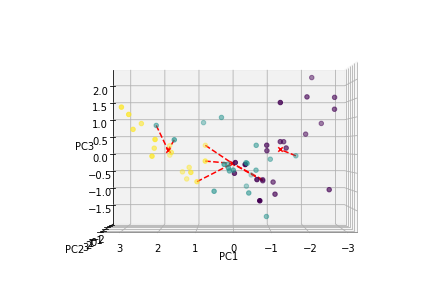

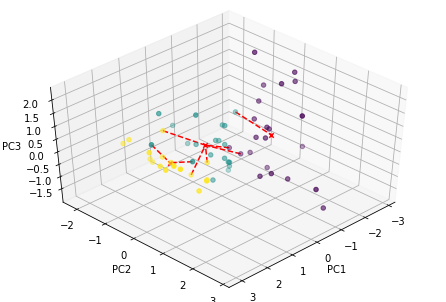

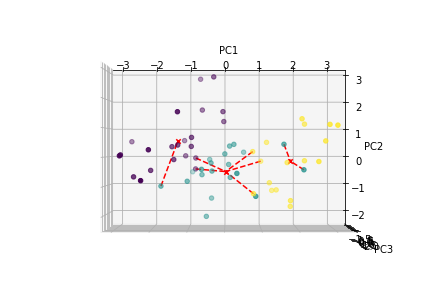

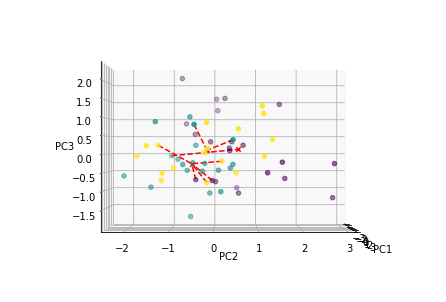

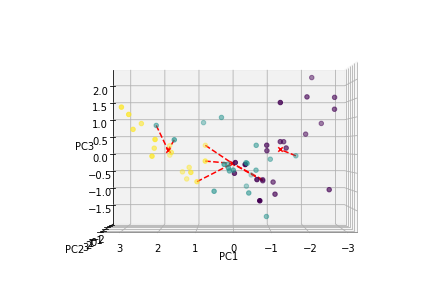

In [130]:


def PlotPC3D(X, Y, Z, elevation, azimut, error_vector):
    fig = plt.figure()
    ax = Axes3D(fig, elev=elevation, azim=azimut)
    ax.scatter(X, Y, Z, c= labels)

    # Plots centroids
    ax.scatter(centroids_C0[0], centroids_C0[1], centroids_C0[2], marker='x', c='r', depthshade=True)
    ax.scatter(centroids_C1[0], centroids_C1[1], centroids_C1[2], marker='x', c='r', depthshade=True)
    ax.scatter(centroids_C2[0], centroids_C2[1], centroids_C2[2], marker='x', c='r', depthshade=True)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    for index, err in error_vector.iterrows():
        err_vec_xs = np.array([transf_all[int(err[0]), 0], centroids[int(err[1]), 0]])
        err_vec_ys = np.array([transf_all[int(err[0]), 1], centroids[int(err[1]), 1]])
        err_vec_zs = np.array([transf_all[int(err[0]), 2], centroids[int(err[1]), 2]])
        ax.plot(err_vec_xs, err_vec_ys, err_vec_zs, 'r--')

    return fig

PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 45, 45, euclid_dist_errors_3PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 90, 270, euclid_dist_errors_3PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 0, 0, euclid_dist_errors_3PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 0, 90, euclid_dist_errors_3PC)


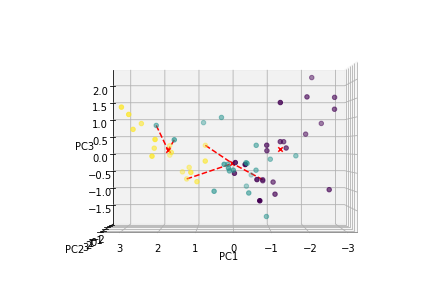

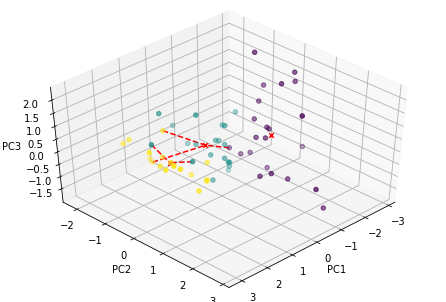

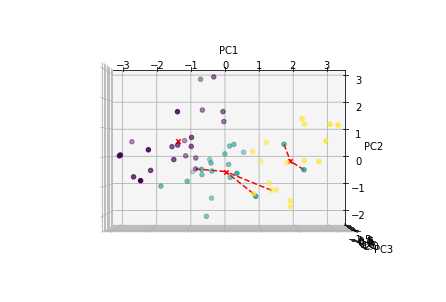

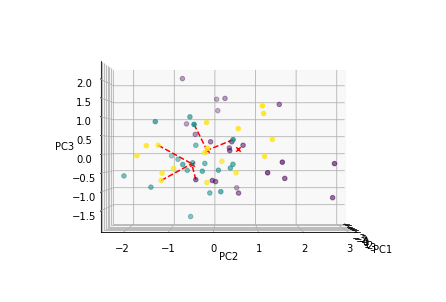

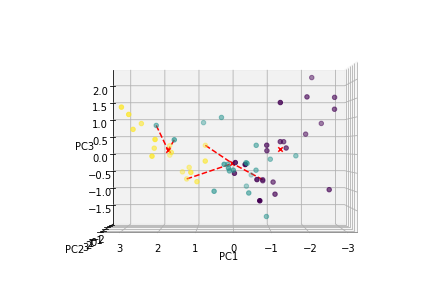

In [131]:
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 45, 45, mahalanobis_dist_errors_2PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 90, 270, mahalanobis_dist_errors_2PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 0, 0, mahalanobis_dist_errors_2PC)
PlotPC3D(transf_all[:, 0], transf_all[:, 1], transf_all[:, 2], 0, 90, mahalanobis_dist_errors_2PC)

# Q3
### a)

In [132]:
n_iter = 100
cumul_error = 0

for test_iter in range(n_iter):
    #Prepare data
    train_set, test_set = train_test_split(transf_all_labeled, train_size=0.8)
    # Train KNN model
    _inv = np.linalg.inv(np.cov(np.array([train_set.loc[:,'attribut1'], train_set.loc[:,'attribut2']])))
    neigh_classifier = KNeighborsClassifier(n_neighbors=5, metric = 'mahalanobis', metric_params ={"VI":_inv})
    neigh_classifier.fit(train_set.loc[:,'attribut1':'attribut2'], train_set.loc[:, 'classe'])
    # Predict using model
    neigh_prediction = neigh_classifier.predict(test_set.loc[:,'attribut1':'attribut2'])
    # Calculate errors on predictions
    neigh_predict_errors = np.abs(neigh_prediction - np.array(test_set.loc[:,'classe'] !=0))
    neigh_predict_errors = np.sum(neigh_predict_errors)
    cumul_error += neigh_predict_errors

average_neigh_error = cumul_error/n_iter
md('L\'erreur moyenne de prediction pour le KNN utilisant la distance de mahalanobis sur {0} itérations est de {1:3.1%}'.format(n_iter, average_neigh_error/12))

L'erreur moyenne de prediction pour le KNN utilisant la distance de mahalanobis sur 100 itérations est de 34.2%

In [134]:
cumul_error = 0

for test_iter in range(n_iter):
    #Prepare data
    train_set, test_set = train_test_split(transf_all_labeled, train_size=0.8)
    # Train KNN model
    _inv = np.linalg.inv(np.cov(np.array([train_set.loc[:,'attribut1'], train_set.loc[:,'attribut2']])))
    centroid_classifier = NearestCentroid(metric = 'mahalanobis')
    centroid_classifier.fit(train_set.loc[:,'attribut1':'attribut2'], train_set.loc[:, 'classe'])
    # Predict using model
    centroid_prediction = centroid_classifier.predict(test_set.loc[:,'attribut1':'attribut2'])
    # Calculate errors on predictions
    centroid_predict_errors = np.abs(centroid_prediction - np.array(test_set.loc[:,'classe'] !=0))
    centroid_predict_errors = np.sum(centroid_predict_errors)
    cumul_error += centroid_predict_errors

average_centroid_error = cumul_error/n_iter
md('L\'erreur moyenne de prediction pour le nearest centroid utilisant la distance de mahalanobis sur {0} itérations est de {1:3.1%}'.format(n_iter, average_centroid_error/12))

L'erreur moyenne de prediction pour le nearest centroid utilisant la distance de mahalanobis sur 100 itérations est de 33.1%

# Q3
### b)

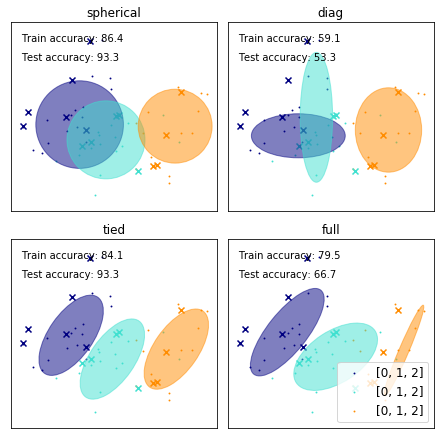

'\nEnd of adapted section\n'

In [143]:
"""
The next section has been adapted from the code available on the Sci-Kit learn web site:
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

Start of adapted section
"""

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(transf_all_labeled.loc[:,'attribut1':'attribut2'], transf_all_labeled.loc[:,'classe'])))

X_train = transf_all_labeled.loc[train_index,'attribut1':'attribut2']
y_train = transf_all_labeled.loc[train_index, 'classe']
X_test = transf_all_labeled.loc[test_index,'attribut1':'attribut2']
y_test = transf_all_labeled.loc[test_index, 'classe']

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        condition = transf_all_labeled['classe'] == n
        data = transf_all_labeled.loc[condition , 'attribut1':'attribut2']
        plt.scatter(data.loc[:, 'attribut1'], data.loc[:, 'attribut2'], s=0.8, color=color,
                    label=[0, 1, 2])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data.loc[:, 'attribut1'], data.loc[:, 'attribut2'], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

"""
End of adapted section
"""